<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 3: Practical - PyTorch Classification <br>
<font color=696880 size=4>
    Javad Hezareh 
    
    
____


### Full Name : Ali Salesi
### Student Number : 99105334
___

# Problem
This assignment uses PyTorch to build and implement a MLP model for solving a classification problem. Our goal is to classify galaxy images into 4 classes: ellipticals, lenticulars, spirals, and irregulars. We will use [EFIGI](https://www.astromatic.net/projects/efigi/) dataset which contains 4458 images.

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import torch.optim as optim
import torch.backends.cudnn as cudnn

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Prepare and Visualize Data (10 Points)

Run the following cell to download dataset. `prepare_data` will return a pandas dataframe which contains three columns. `name` is the name of image that you can find that in `./efigi-1.6/png`, `class_name` is the type of galaxy in that image and `class_label` is a numerical label for this class.

In [3]:
# run this cell to download and prepare data
from data_utils import download_data, prepare_data

download_data()
df = prepare_data('./efigi-1.6/EFIGI_attributes.txt')

df.describe()

,class_label
count,4458.000000
mean,1.820996
std,0.647245
min,0.000000
25%,2.000000
50%,2.000000
75%,2.000000
max,3.000000


In [4]:
##############################################################
##            Visualize 4 sample from each class            ##
##                        Your Code                         ##
##############################################################
images = [None for _ in range(df.shape[0])]
labels = [None for _ in range(df.shape[0])]
classes = ['Ellipticals', 'Lenticulars', 'Spirals', 'Irregulars']
for i, row in tqdm(df.iterrows(), total=df.shape[0]):
    images[i] = np.array(Image.open('./efigi-1.6/png/' + row[0] + '.png').convert('RGB'))
    labels[i] = row[2]
images = np.array(images, dtype=int).transpose(0, 3, 1, 2)
labels = np.array(labels)

100%|██████████| 4458/4458 [00:08<00:00, 528.10it/s]


In [5]:
df.groupby(['class_label', 'class_name']).size().reset_index(name='Freq').sort_values('Freq', ascending=False)

,class_label,class_name,Freq
2,2,Spirals,3315
1,1,Lenticulars,537
3,3,Irregulars,317
0,0,Ellipticals,289


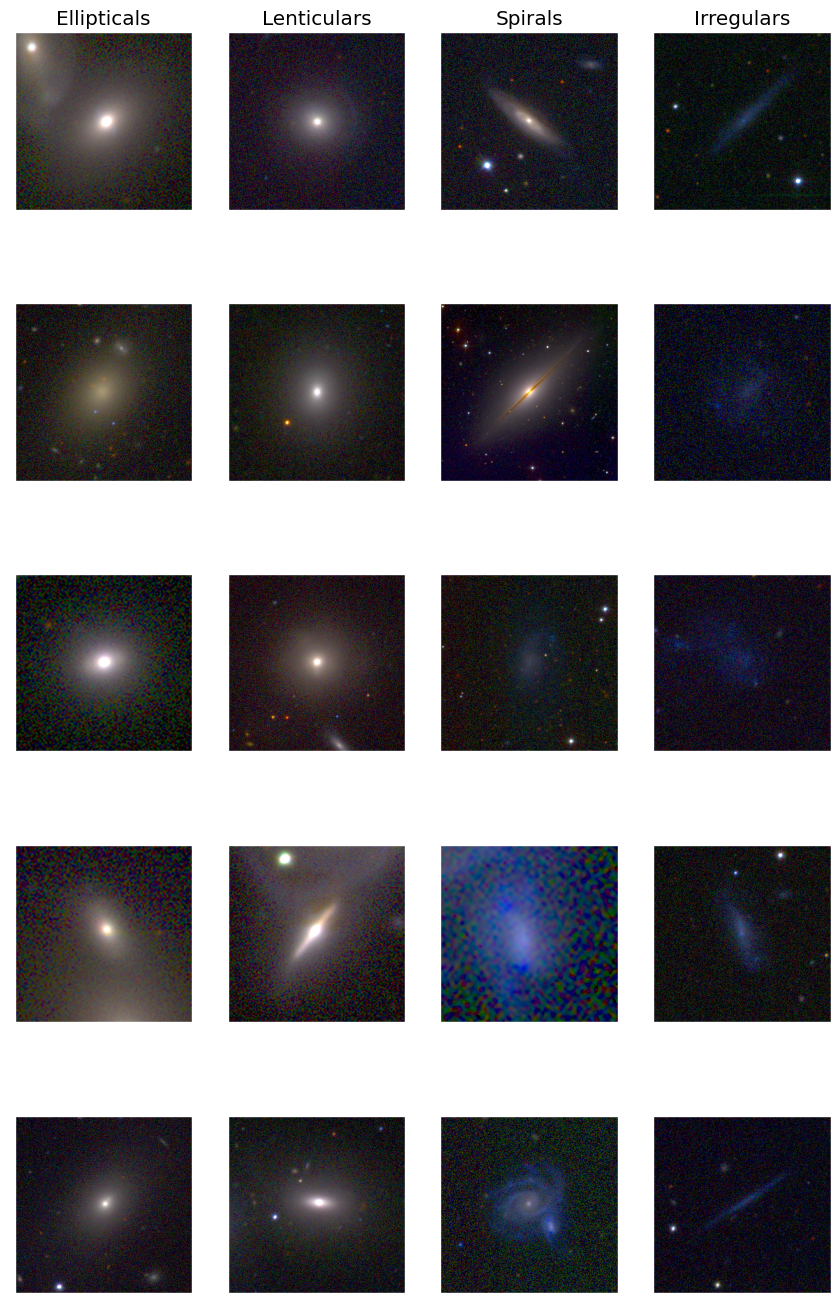

In [6]:
imgCls = [[] for i in range(4)]
for i, image in enumerate(images):
    if len(imgCls[labels[i]]) < 5:
        imgCls[labels[i]].append(i)
fig=plt.figure(figsize=(27, 17))
for i in range(4):
    for j, imgId in enumerate(imgCls[i]):
        fig.add_subplot(5, 10, 10 * j + i + 1)
        plt.imshow(images[imgId].transpose(1, 2, 0))
        plt.xticks([])
        plt.yticks([])
        if j == 0:
            plt.title("{}"
              .format(classes[labels[imgId]]))
plt.show()

# Define Dataset (20 Points)

In [61]:
class GalaxyDataSet(Dataset):
    def __init__(self, images, labels):
        self.images = torch.tensor(images).float()
        self.labels = torch.tensor(labels).long()

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        return (self.images[idx], self.labels[idx])
np.random.seed(11)
train_idx, test_idx = train_test_split(np.arange(images.shape[0]), test_size=0.2)
train_idx, val_idx = train_test_split(train_idx, test_size=0.2)
train_ds = GalaxyDataSet(images[train_idx], labels[train_idx])
val_ds = GalaxyDataSet(images[val_idx], labels[val_idx])
test_ds = GalaxyDataSet(images[test_idx], labels[test_idx])
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=128, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=128, shuffle=False)

# Define Model (20 Points)

In [69]:
class RNet(nn.Module):
    def __init__(self):
        super(RNet, self).__init__()
        self.base = nn.Sequential(
            nn.AdaptiveAvgPool2d(48),
            nn.Flatten(),
        )
        self.layers = nn.Sequential(
            nn.Linear(6912, 2048),
            nn.Dropout(0.25),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Linear(2048, 512),
            nn.Dropout(0.15),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        out = self.base(x)

        out = self.layers(out)
        return out


# Train Model (30 Points)

In [70]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function ant etc                                     ##
######################################################################
model = RNet()
model.to(device)
print('params:', sum(p.numel() for p in model.parameters() if p.requires_grad))
if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
tl = dict()
ta = dict()
tf = dict()
vl = dict()
va = dict()
vf = dict()
best_valid_acc = 0


def train(pbar, epoch):
    global best_valid_acc
    model.train()
    train_loss = 0
    valid_loss = 0
    train_correct = 0
    train_total = 0
    train_f1 = 0
    valid_correct = 0
    valid_total = 0
    valid_f1 = 0
    for batch_idx, (inputs, targets) in enumerate(train_dl):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += targets.size(0)
        train_correct += predicted.eq(targets).sum().item()
        train_f1 += f1_score(targets.cpu(), predicted.cpu(), average='macro') * len(targets)

    model.eval()
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_dl):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            valid_loss += loss.item()
            _, predicted = outputs.max(1)
            valid_total += targets.size(0)
            valid_correct += predicted.eq(targets).sum().item()
            valid_f1 += f1_score(targets.cpu(), predicted.cpu(), average='macro') * len(targets)

    tl[epoch] = train_loss / (len(train_dl))
    ta[epoch] = 100.0 * train_correct / train_total
    tf[epoch] = train_f1 / train_total
    pbar.set_description(
        f'Epoch [{epoch}] | Train | Loss: {tl[epoch]:.3f} | Accuracy: {ta[epoch]:.3f} | F1 Score: {tf[epoch]:.3f}')

    vl[epoch] = valid_loss / (len(val_dl))
    va[epoch] = 100.0 * valid_correct / valid_total
    vf[epoch] = valid_f1 / valid_total
    pbar.set_postfix_str(f'Validation | Loss: {vl[epoch]:.3f} | Accuracy: {va[epoch]:.3f} | F1 Score: {vf[epoch]:.3f}')
    if va[epoch] > best_valid_acc:
        best_valid_acc = va[epoch]
        torch.save(model.state_dict(), 'best_rrnet.pts')


pbar = tqdm(range(1, 101))
for ep in pbar:
    train(pbar, ep)
    scheduler.step()


params: 15217162


Epoch [100] | Train | Loss: 0.037 | Accuracy: 99.264 | F1 Score: 0.979: 100%|██████████| 100/100 [03:15<00:00,  1.96s/it, Validation | Loss: 0.684 | Accuracy: 79.552 | F1 Score: 0.564]


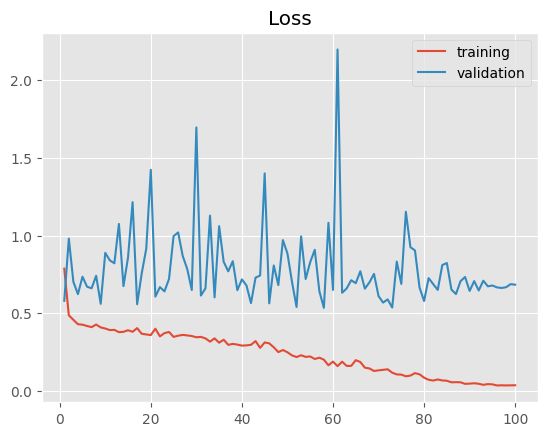

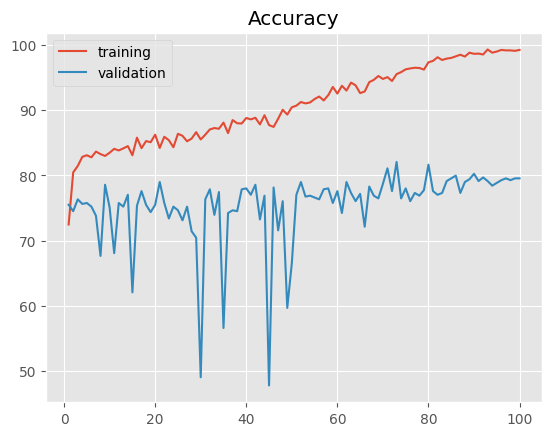

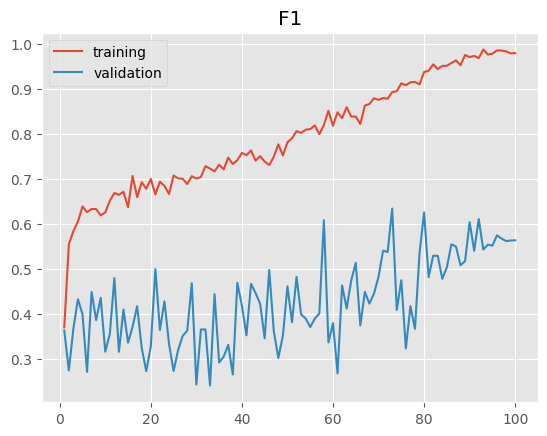

In [71]:
plt.plot(*zip(*sorted(tl.items())), label='training')
plt.plot(*zip(*sorted(vl.items())), label='validation')
plt.title('Loss')
plt.legend()
plt.show()
plt.plot(*zip(*sorted(ta.items())), label='training')
plt.plot(*zip(*sorted(va.items())), label='validation')
plt.title('Accuracy')
plt.legend()
plt.show()
plt.plot(*zip(*sorted(tf.items())), label='training')
plt.plot(*zip(*sorted(vf.items())), label='validation')
plt.title('F1')
plt.legend()
plt.show()

# Test Model (20)

Test Loss: 0.523	Test Accuracy: 79.933
[[ 35  13  15   1]
 [ 16  29  49   1]
 [  6  12 621  31]
 [  3   0  32  28]]
0.575212149965824


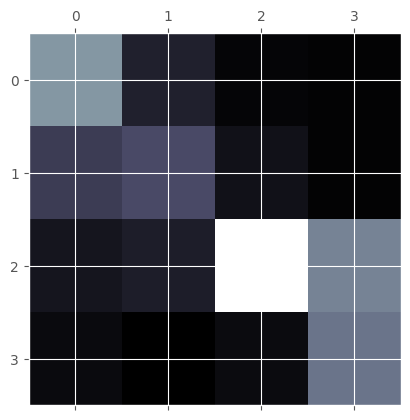

In [72]:
model.load_state_dict(torch.load('best_rrnet.pts'))

def f_score(confusion_matrix):
    N = confusion_matrix.shape[0]
    pr_matrix = np.zeros((N, 3))
    for i in range(N):
        pr_matrix[i, 0] = confusion_matrix[i, i]
        pr_matrix[i, 1] = np.sum(confusion_matrix[i]) - confusion_matrix[i, i]
        pr_matrix[i, 2] = np.sum(confusion_matrix[:, i]) - confusion_matrix[i, i]
    f_matrix = np.zeros(N)
    for i in range(N):
        total = (2 * pr_matrix[i, 0] + pr_matrix[i, 1] + pr_matrix[i, 2])
        if total > 0:
            f_matrix[i] = (2 * pr_matrix[i, 0]) / total
        else:
            f_matrix[i] = 0
    f1_score = np.mean(f_matrix)

    return f1_score


errors = dict([(j, dict([(i, []) for i in range(10)])) for j in range(10)])
def test():
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0
    conf = None
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_dl):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            test_total += targets.size(0)
            test_correct += predicted.eq(targets).sum().item()
            loc_conf = confusion_matrix(targets.cpu(), predicted.cpu(), labels=[0, 1, 2, 3])
            if conf is None:
                conf = loc_conf
            else:
                conf += loc_conf
    
    tl = test_loss / (len(test_dl))
    ta = 100.0 * test_correct / test_total
    print(f'Test Loss: {tl:.3f}', end='\t')
    print(f'Test Accuracy: {ta:.3f}')
    plt.matshow(conf / np.sum(conf, axis=1), cmap='bone')
    print(conf)
    print(f_score(conf))
test()